## GAN (Generative Adversarial Networks)

- $D(x)$ - 가짜/진짜 이미지 판별, $x$는 이미지 (구분자)
- $G(z)$ - 실제 이미지로 착각할만한 정교한 이미지 생성 (생성자)
  - $z$: 정규분포에서 뽑은 잠재공간 벡터 (latent space vector)

  - latent space vector는 쉽게 생각해 정규분포를 따르는 n개의 원소를 가진 vector라 볼 수 있다. 즉, 정규분포에서 n개의 원소를 추출한 것과 같다. 

  - $G(z)$ 는 $z$ 벡터를 원하는 데이터 차원으로 대응시키는 신경망으로 볼 수 있다. 

  - $G$ 의 목적은 $p_{data}$
  에서 얻을 수 있는 학습 데이터들의 분포를 추정하여, 모사한 $p_g$의 분포를 이용해 가짜 데이터들을 만드는 것

<br>

- **손실함수:** $min_Gmax_DV(D,G)=E_{x∼p_{data}}(x)[logD(x)]+E_{z∼p_z(z)}[log(1−D(G(z)))]$
  - $D(G(z))$: $G$가 출력한 결과물이 실제 이미지일 0~1사이의 상수의 확률
  - $logD(x)$: $D$가 이미지의 참/거짓을 정확히 판별할 확률
  - $log(1-D(G(z)))$: 생성한 이미지를 $D$ 가 가짜로 판별할 확률

  - $D$가 이미지의 참/거짓을 정확히 판별할 확률($logD(x)$)은 최대화시키고, $D$가 생성한 이미지를 가짜로 판별할 확률($log(1-D(G(z)))$)을 최소화시킨다는 점에서 $D$와 $G$는 최대최소(minmax) 게임을 하는 것과 동일
  - 이론적으로는, 이 최대최소게임은 $p_g$ = $p_{data}$ 이고, 구분자에 입력된 데이터가 1/2의 무작위 확률로 참/거짓이 판별될때 해답에 이른다.

## DCGAN

💡 생성자와 구분자에서 **합성곱 신경망(convolution)**과 **전치 합성곱 신경망(convolution-transpose)**을 사용함


- **Discriminator**: convolution, batch norm, LeakyReLU 
- **Generator**: convolutional-transpose, 배치 정규화(batch norm), ReLU 
  - **전치 합성곱 신경망(convolutional-transpose)**: 잠재공간 벡터($z$)를 이미지와 같은 차원을 갖도록 변환시켜주는 역할을 함
  - 작은 CHW 데이터를 가중치들을 이용해 더 큰 CHW로 업샘플링해주는 것

In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# 코드 실행결과의 동일성을 위해 무작위 시드를 설정
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


### 설정값

- `dataroot` - 데이터셋 폴더의 경로

- `workers` - DataLoader에서 데이터를 불러올 때 사용할 쓰레드의 개수

- `batch_size` - 학습에 사용할 배치 크기, DCGAN에서는 128을 사용

- `image_size` - 학습에 사용되는 이미지의 크기

- `nc` - 입력 이미지의 채널 개수

- `nz` - 잠재공간 벡터의 원소들 개수

- `ngf` - 생성자를 통과할때 만들어질 특징 데이터의 채널개수

- `ndf` - 구분자를 통과할때 만들어질 특징 데이터의 채널개수

- `num_epochs` - 학습시킬 에폭 수

- `lr` - 모델의 학습률, DCGAN에서 사용된대로 0.0002로 설정한다

- `beta1` - Adam 옵티마이저에서 사용할 beta1 하이퍼파라미터 값, 논문에서 사용한대로 0.5로 설정함


In [ ]:
dataroot = "data/celeba/"
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5

## 1. Data

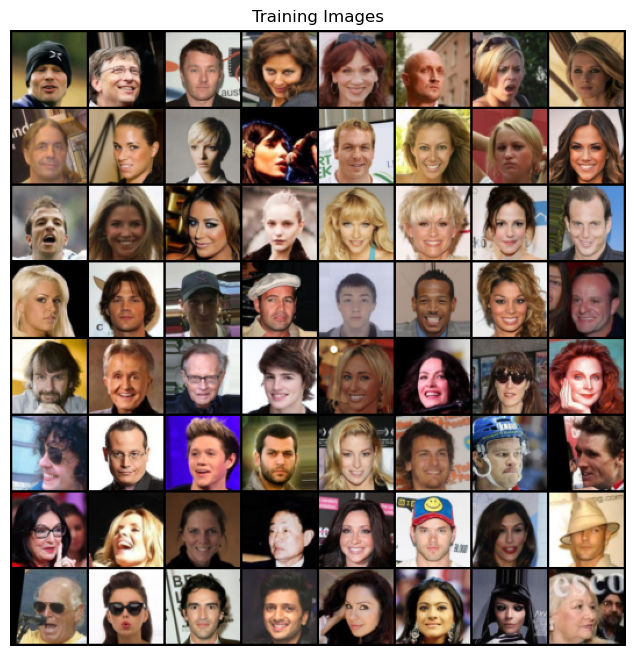

In [ ]:
dataset = dataset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # (-1 ~ 1)로 scale
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# 학습 데이터 출력
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## 2. Model

In [ ]:
# netG와 netD에 적용시킬 가중치 초기화 함수
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator
- $z$를 image로 변환
- stride 2를 가진 convolutional-transpose를 사용
  - 활성화 함수로 relu를 사용하다가 마지막 출력에는 tanh를 사용
  - fc layer가 없음
  - Batch norm을 적용하여 gradient가 잘 흐르게 해줌

In [ ]:
# 생성자 코드

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # in_channels(input vector size), out_channels, 4x4, stride 1, padding 0
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 생성자
netG = Generator().to(device)

# 모든 가중치의 평균을 0, 분산을 0.02로 초기화
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### Discriminator
- **strided convolution** 사용
  - 학습 parameter가 존재하지 않는 Pooling layer 대신, convolution layer에 stride를 2만큼 줘서 신경망 내에서 스스로 pooling 함수를 학습하게 됨
  - batch norm, LeakyReLU

In [ ]:
# 구분자 코드

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# 구분자
netD = Discriminator().to(device)

# 모든 가중치의 평균을 0, 분산을 0.02로 초기화 하기 위해
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## 3. Loss Function, Optimizer

In [ ]:
# BCELoss
criterion = nn.BCELoss()

# 잠재 공간 벡터
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# 학습에 사용되는 참/거짓의 label
real_label = 1.
fake_label = 0.

# optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## 4. Train
- Discriminator
  - $log(D(x))+log(1−D(G(z)))$를 최대화시키는 방향으로 학습
    > 1. 진짜 data들로만 이루어진 배치로 $D$ 통과시키고, $log(D(x))$의 손실값 구하고 역전파
     그 다음 가짜 data들로만 이루어진 배치를 만들어 $D$에 통과시키고,  
    2. 그 출력값으로 $log(1-D(G(z)))$ 의 손실값을 계산해 역전파
    3. 두 스텝에서의 gradient를 accumulate해줘야 함

- Generator
  -  $log(D(G(z))$ 를 최대화 하는 방식으로 학습
  - Discriminator가 Generator의 가짜 이미지를 판별해주고, **진짜 label 값(1)**을 이용해서 $G$의 손실값을 구해줌 -> BCELoss의 일부분을 사용해주기 위해


In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        # (1) D 신경망 업데이트: log(D(x)) + log(1 - D(G(z))) 최대화
        ## 진짜 데이터들로 학습
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        # 배치 사이즈만큼의 라벨 생성
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        # 진짜 데이터들로 이루어진 배치를 D에 통과
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## 가짜 데이터들로 학습
        # 생성자에 사용할 잠재공간 벡터 생성
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # G를 이용해 가짜 이미지를 생성
        fake = netG(noise)
        label.fill_(fake_label)
        # D를 이용해 데이터의 진위 판별
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # 가짜 이미지, 진짜 이미지에서 구한 손실값들을 더함
        # 이때 errD는 역전파에서 사용되지 않고, 이후 학습 상태를 리포팅(reporting)할 때 사용함
        errD = errD_real + errD_fake
        # D를 업데이트 합니다
        optimizerD.step()


        # (2) G 신경망 업데이트: log(D(G(z)))를 최대화
        netG.zero_grad()
        label.fill_(real_label)  # 생성자의 손실값을 구하기 위해 진짜 라벨을 사용
        # D에 다시 가짜 데이터를 통과
        # 이때 G는 업데이트되지 않았지만, D가 업데이트 되었기 때문에 앞선 손실값가 다른 값이 나오게 됨
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))


        G_losses.append(errG.item())
        D_losses.append(errD.item())


        # fixed_noise를 통과시킨 G의 출력값을 저장
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[1/5][0/1583]	Loss_D: 1.9968	Loss_G: 4.8971	D(x): 0.5175	D(G(z)): 0.6218 / 0.0143
[1/5][50/1583]	Loss_D: 0.1095	Loss_G: 26.0209	D(x): 0.9751	D(G(z)): 0.0000 / 0.0000
[1/5][100/1583]	Loss_D: 0.5724	Loss_G: 13.1621	D(x): 0.9541	D(G(z)): 0.3475 / 0.0000
[1/5][150/1583]	Loss_D: 0.8934	Loss_G: 2.7615	D(x): 0.5623	D(G(z)): 0.0371 / 0.0914
[1/5][200/1583]	Loss_D: 0.3031	Loss_G: 3.4547	D(x): 0.8326	D(G(z)): 0.0536 / 0.0686
[1/5][250/1583]	Loss_D: 0.5602	Loss_G: 4.8742	D(x): 0.8079	D(G(z)): 0.2223 / 0.0138
[1/5][300/1583]	Loss_D: 1.0739	Loss_G: 4.8400	D(x): 0.4852	D(G(z)): 0.0203 / 0.0217
[1/5][350/1583]	Loss_D: 0.8211	Loss_G: 6.1294	D(x): 0.9480	D(G(z)): 0.4617 / 0.0066
[1/5][400/1583]	Loss_D: 0.6122	Loss_G: 2.5358	D(x): 0.7297	D(G(z)): 0.1165 / 0.1200
[1/5][450/1583]	Loss_D: 0.4946	Loss_G: 4.9520	D(x): 0.8798	D(G(z)): 0.2311 / 0.0248
[1/5][500/1583]	Loss_D: 0.4876	Loss_G: 6.4377	D(x): 0.9171	D(G(z)): 0.2781 / 0.0046
[1/5][550/1583]	Loss_D: 0.5776	Loss_G: 2.9791	D(x):

[4/5][50/1583]	Loss_D: 2.8929	Loss_G: 0.8649	D(x): 0.0879	D(G(z)): 0.0129 / 0.4897
[4/5][100/1583]	Loss_D: 0.4085	Loss_G: 2.6027	D(x): 0.7762	D(G(z)): 0.1189 / 0.0925
[4/5][150/1583]	Loss_D: 0.9024	Loss_G: 4.4489	D(x): 0.9464	D(G(z)): 0.5324 / 0.0177
[4/5][200/1583]	Loss_D: 1.1926	Loss_G: 5.0470	D(x): 0.9439	D(G(z)): 0.6194 / 0.0109
[4/5][250/1583]	Loss_D: 0.5977	Loss_G: 3.6437	D(x): 0.8548	D(G(z)): 0.3213 / 0.0354
[4/5][300/1583]	Loss_D: 0.6942	Loss_G: 4.4258	D(x): 0.8955	D(G(z)): 0.3980 / 0.0204
[4/5][350/1583]	Loss_D: 1.7426	Loss_G: 0.9051	D(x): 0.2578	D(G(z)): 0.0570 / 0.4885
[4/5][400/1583]	Loss_D: 0.8672	Loss_G: 3.6632	D(x): 0.9335	D(G(z)): 0.5174 / 0.0336
[4/5][450/1583]	Loss_D: 0.5489	Loss_G: 3.6144	D(x): 0.8738	D(G(z)): 0.2985 / 0.0359
[4/5][500/1583]	Loss_D: 1.3970	Loss_G: 4.6574	D(x): 0.9434	D(G(z)): 0.6818 / 0.0170
[4/5][550/1583]	Loss_D: 0.6239	Loss_G: 3.1953	D(x): 0.9077	D(G(z)): 0.3746 / 0.0540
[4/5][600/1583]	Loss_D: 0.5236	Loss_G: 2.8692	D(x): 0.7874	D(G(z)): 0.2113 / 

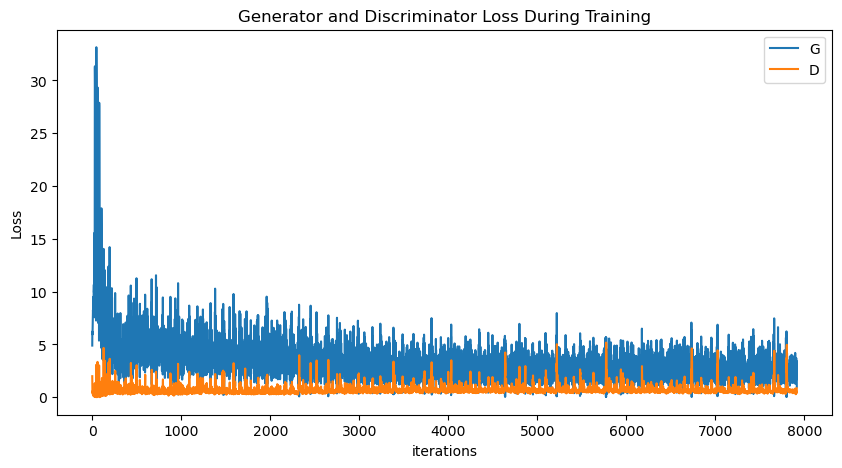

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

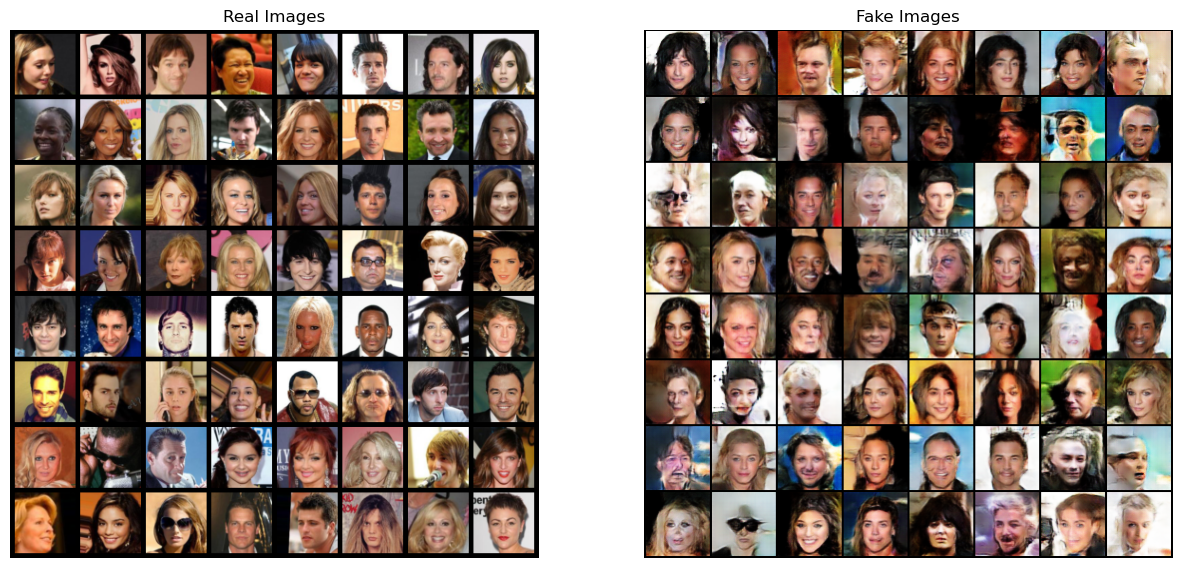

In [ ]:
# 진짜 데이터
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 가짜 이미지 출력
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()